# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import pytorch_lightning as pl
import torch 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
PyTorch Lightning -> {pl.__version__}
Torch -> {torch.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
PyTorch Lightning -> 1.6.1
Torch -> 1.11.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
path = Path('../../datasets/Ch13/')
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

daily_weather.ffill(inplace=True)

## Tranform the data sets
### Windowing

In [5]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [6]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

### Scale and split data

In [7]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [8]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [9]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



### Split into X and Y (Features and Target)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [11]:
def features_target(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [42]:
numpy_array = train_air.values
type(numpy_array)

numpy.ndarray

In [41]:
torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)

torch.Tensor

In [43]:
from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)

numpy.ndarray

In [12]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [29]:
# returns a Tensor object
type(x_test_air)

torch.Tensor

In [13]:
y_train_air.shape

torch.Size([102, 1])

In [14]:
x_train_air.shape

torch.Size([102, 5, 1])

# RNN/LSTM in PyTorch

## RNN Model
* The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [63]:
issubclass(RNN, nn.Module)

True

In [66]:
issubclass(RNN, nn.RNN)

False

In [83]:
def train(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    plt.figure(figsize=(20, 10))
    
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    plt.title(f'{model_type}: Loss and Validation Loss per epoch')
    plt.plot(history['loss'], 'k--', label='loss')
    plt.plot(history['val_loss'], 'k', label='val_loss')
    plt.legend()
    
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    plt.title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    plt.legend(); plt.show()
    
    return model, history

### Air Passenger

In [77]:
params_air = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 1000,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_air, y_train_air),
'val_data': (x_val_air, y_val_air),
'test_data': (x_test_air, y_test_air),
'idx': test_air.index,
'scale': scale_air}

0/1000 - Loss:  0.7130659222602844, val_loss: 1.2721532583236694
25/1000 - Loss:  0.12057366967201233, val_loss: 0.2965744733810425
50/1000 - Loss:  0.06390534341335297, val_loss: 0.2113918513059616
75/1000 - Loss:  0.054560452699661255, val_loss: 0.11945802718400955
100/1000 - Loss:  0.02817821316421032, val_loss: 0.08031191676855087
125/1000 - Loss:  0.020478935912251472, val_loss: 0.06849043816328049
150/1000 - Loss:  0.01881198026239872, val_loss: 0.06367381662130356
175/1000 - Loss:  0.01949777454137802, val_loss: 0.06538866460323334
200/1000 - Loss:  0.0242198184132576, val_loss: 0.06767282634973526
225/1000 - Loss:  0.023461440578103065, val_loss: 0.06262218952178955
250/1000 - Loss:  0.01923736371099949, val_loss: 0.06607310473918915
275/1000 - Loss:  0.017492394894361496, val_loss: 0.07251174002885818
300/1000 - Loss:  0.022050322964787483, val_loss: 0.06598527729511261
325/1000 - Loss:  0.02251298539340496, val_loss: 0.07760119438171387
350/1000 - Loss:  0.022406108677387238,

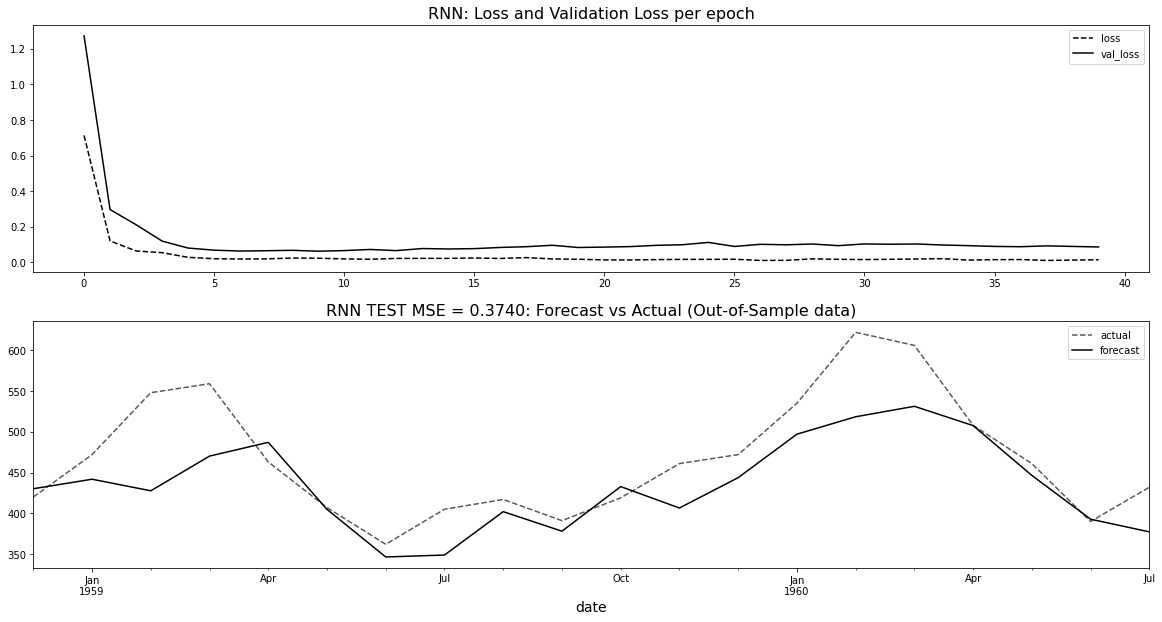

In [78]:
air_rnn, history_a_rnn = train('RNN', **params_air)

### Avg Daily Temperature

0/1000 - Loss:  1.6718984842300415, val_loss: 0.9361973404884338
20/1000 - Loss:  0.4428713917732239, val_loss: 0.3530988395214081
40/1000 - Loss:  0.39926910400390625, val_loss: 0.30674606561660767
60/1000 - Loss:  0.37042930722236633, val_loss: 0.3017756938934326
80/1000 - Loss:  0.3547682762145996, val_loss: 0.2988491654396057
100/1000 - Loss:  0.3316090703010559, val_loss: 0.2962408661842346
120/1000 - Loss:  0.32169657945632935, val_loss: 0.3058204650878906
140/1000 - Loss:  0.3010525107383728, val_loss: 0.33817198872566223
160/1000 - Loss:  0.30392470955848694, val_loss: 0.3295018672943115
180/1000 - Loss:  0.2920422852039337, val_loss: 0.3484979569911957
200/1000 - Loss:  0.2750971019268036, val_loss: 0.3352835178375244
220/1000 - Loss:  0.26687106490135193, val_loss: 0.3391712009906769
240/1000 - Loss:  0.2637940049171448, val_loss: 0.3571034371852875
260/1000 - Loss:  0.239491805434227, val_loss: 0.42728760838508606
280/1000 - Loss:  0.23771798610687256, val_loss: 0.3447544574

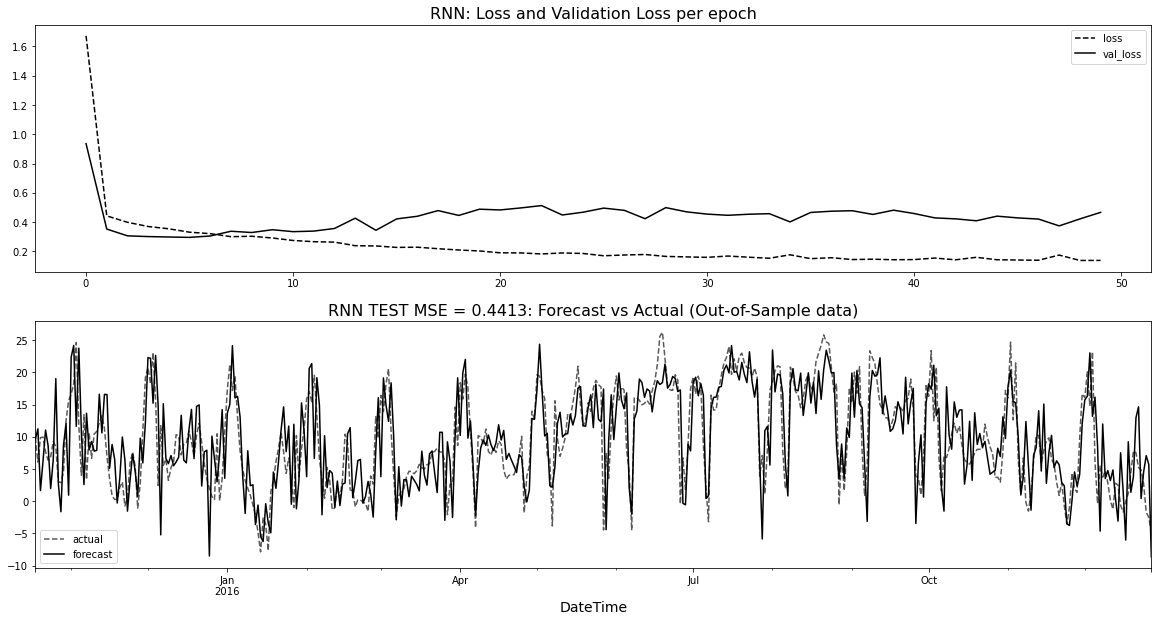

In [19]:
params_dw = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 1000,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_dw, y_train_dw),
'val_data': (x_val_dw, y_val_dw),
'test_data': (x_test_dw, y_test_dw),
'idx': test_dw.index,
'scale': scale_dw}

dw_rnn, history_dw_rnn = train('RNNA', **params_dw)

### Energy Consumption

0/1000 - Loss:  0.9983494281768799, val_loss: 1.4537527561187744
20/1000 - Loss:  0.1304968297481537, val_loss: 0.23498329520225525
40/1000 - Loss:  0.07529515027999878, val_loss: 0.1727219671010971
60/1000 - Loss:  0.058468032628297806, val_loss: 0.1627955287694931
80/1000 - Loss:  0.057878877967596054, val_loss: 0.16312521696090698
100/1000 - Loss:  0.05907106772065163, val_loss: 0.1595308780670166
120/1000 - Loss:  0.059488050639629364, val_loss: 0.16356733441352844
140/1000 - Loss:  0.06352429836988449, val_loss: 0.16392634809017181
160/1000 - Loss:  0.05102109536528587, val_loss: 0.16913652420043945
180/1000 - Loss:  0.057290028780698776, val_loss: 0.16996094584465027
200/1000 - Loss:  0.05026515573263168, val_loss: 0.18074801564216614
220/1000 - Loss:  0.050373248755931854, val_loss: 0.16158351302146912
240/1000 - Loss:  0.04737328737974167, val_loss: 0.1697843372821808
260/1000 - Loss:  0.05107806250452995, val_loss: 0.17531181871891022
280/1000 - Loss:  0.04649940878152847, val

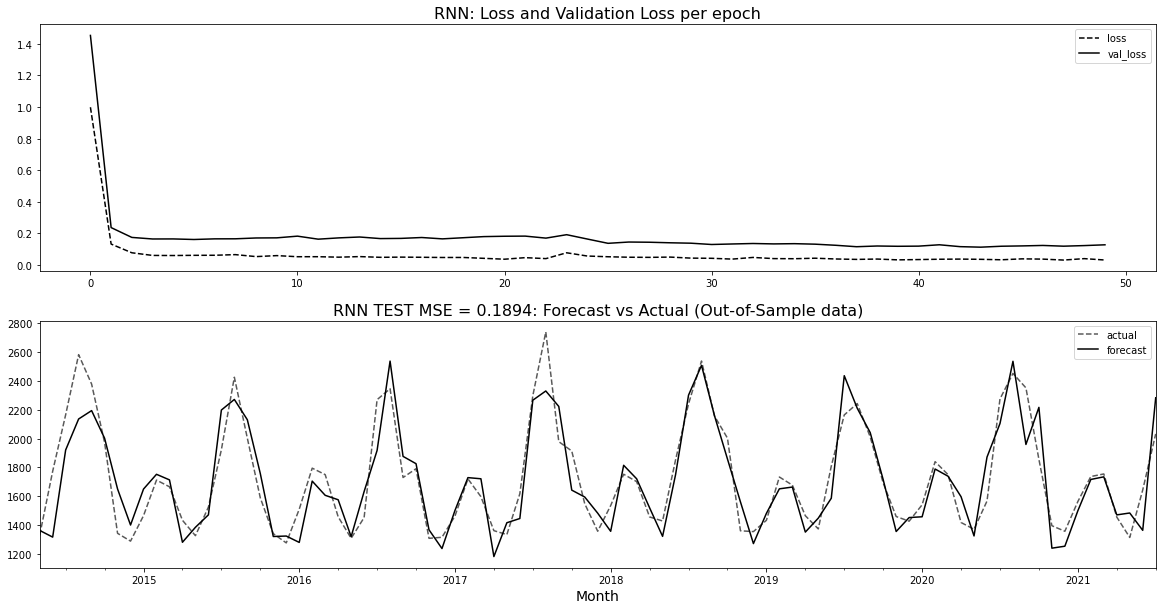

In [20]:
params_en = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 1000,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}

en_rnn, history_en_rnn = train('RNN', **params_en)

## LSTM Model 
* The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

### Air Passenger

0/1000 - Loss:  0.9848157167434692, val_loss: 2.379291534423828
25/1000 - Loss:  0.18827052414417267, val_loss: 0.3979814648628235
50/1000 - Loss:  0.10477813333272934, val_loss: 0.4851474165916443
75/1000 - Loss:  0.06907756626605988, val_loss: 0.35448604822158813
100/1000 - Loss:  0.04057101532816887, val_loss: 0.19846947491168976
125/1000 - Loss:  0.0559241808950901, val_loss: 0.1388261467218399
150/1000 - Loss:  0.029634496197104454, val_loss: 0.1738443225622177
175/1000 - Loss:  0.04143138602375984, val_loss: 0.2154928594827652
200/1000 - Loss:  0.028388282284140587, val_loss: 0.18423309922218323
225/1000 - Loss:  0.025288298726081848, val_loss: 0.12452694773674011
250/1000 - Loss:  0.03360618278384209, val_loss: 0.1138884574174881
275/1000 - Loss:  0.01624647155404091, val_loss: 0.1381978988647461
300/1000 - Loss:  0.016240384429693222, val_loss: 0.11679323762655258
325/1000 - Loss:  0.022666888311505318, val_loss: 0.11251558363437653
350/1000 - Loss:  0.02194320596754551, val_lo

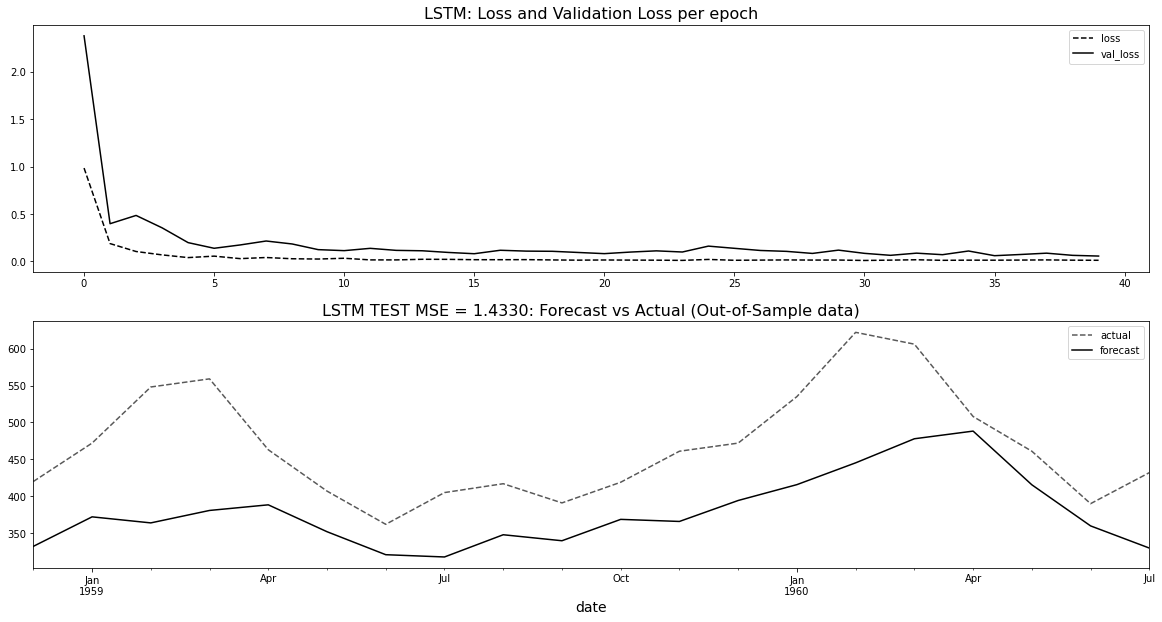

In [22]:
air_lstm, history_a_lstm = train('LSTM', **params_air)

### Avg Daily Temperature

0/1000 - Loss:  0.9913718700408936, val_loss: 0.7293002009391785
20/1000 - Loss:  0.4479231536388397, val_loss: 0.31131523847579956
40/1000 - Loss:  0.377800315618515, val_loss: 0.3010953962802887
60/1000 - Loss:  0.352021723985672, val_loss: 0.29826492071151733
80/1000 - Loss:  0.30769845843315125, val_loss: 0.2942788302898407
100/1000 - Loss:  0.26445937156677246, val_loss: 0.2596046030521393
120/1000 - Loss:  0.24751608073711395, val_loss: 0.25535768270492554
140/1000 - Loss:  0.22642956674098969, val_loss: 0.24556273221969604
160/1000 - Loss:  0.20845334231853485, val_loss: 0.2800995111465454
180/1000 - Loss:  0.2109224796295166, val_loss: 0.31392529606819153
200/1000 - Loss:  0.19960850477218628, val_loss: 0.3368629217147827
220/1000 - Loss:  0.19167986512184143, val_loss: 0.31053224205970764
240/1000 - Loss:  0.18424050509929657, val_loss: 0.3179457485675812
260/1000 - Loss:  0.17511969804763794, val_loss: 0.3511723279953003
280/1000 - Loss:  0.17087849974632263, val_loss: 0.3770

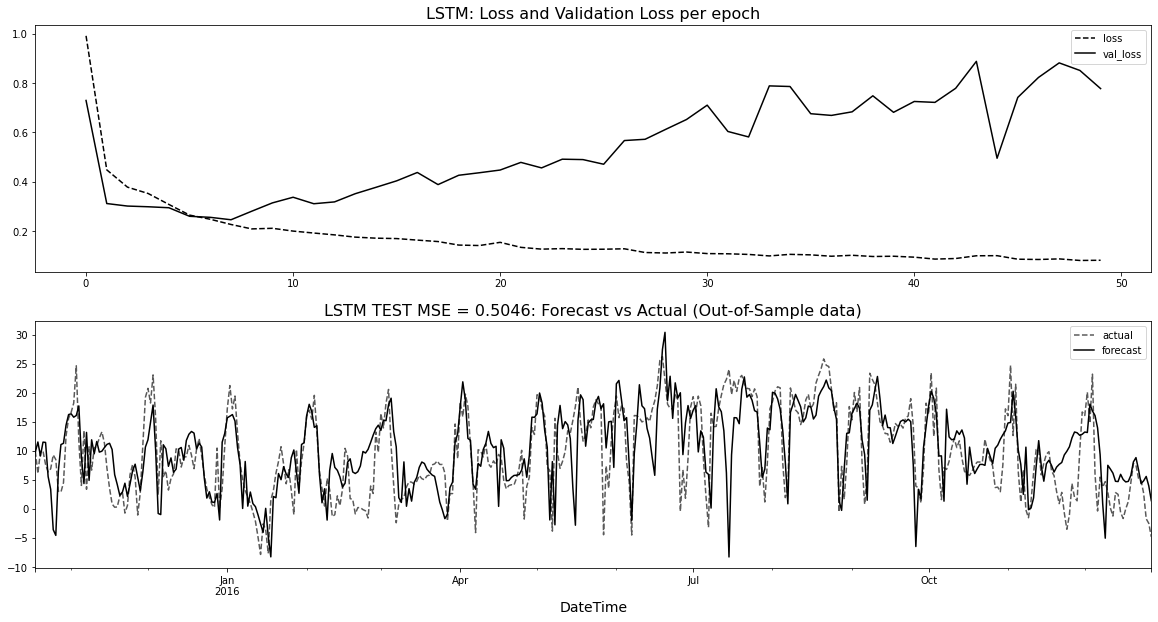

In [23]:
dw_lstm, history_dw_lstm = train('LSTM', **params_dw)

### Energy Consumption

0/1000 - Loss:  1.0267080068588257, val_loss: 1.5354076623916626
20/1000 - Loss:  0.20115192234516144, val_loss: 0.4717279374599457
40/1000 - Loss:  0.10345885902643204, val_loss: 0.2367960512638092
60/1000 - Loss:  0.07451293617486954, val_loss: 0.22029156982898712
80/1000 - Loss:  0.0682888925075531, val_loss: 0.19972854852676392
100/1000 - Loss:  0.06006765738129616, val_loss: 0.1851637363433838
120/1000 - Loss:  0.05765329673886299, val_loss: 0.16939158737659454
140/1000 - Loss:  0.052727047353982925, val_loss: 0.1556137502193451
160/1000 - Loss:  0.05332569405436516, val_loss: 0.16456176340579987
180/1000 - Loss:  0.04663284868001938, val_loss: 0.14350202679634094
200/1000 - Loss:  0.04646613448858261, val_loss: 0.13981620967388153
220/1000 - Loss:  0.042773451656103134, val_loss: 0.14932407438755035
240/1000 - Loss:  0.05087508633732796, val_loss: 0.14734768867492676
260/1000 - Loss:  0.03784167766571045, val_loss: 0.1734476089477539
280/1000 - Loss:  0.04339870810508728, val_los

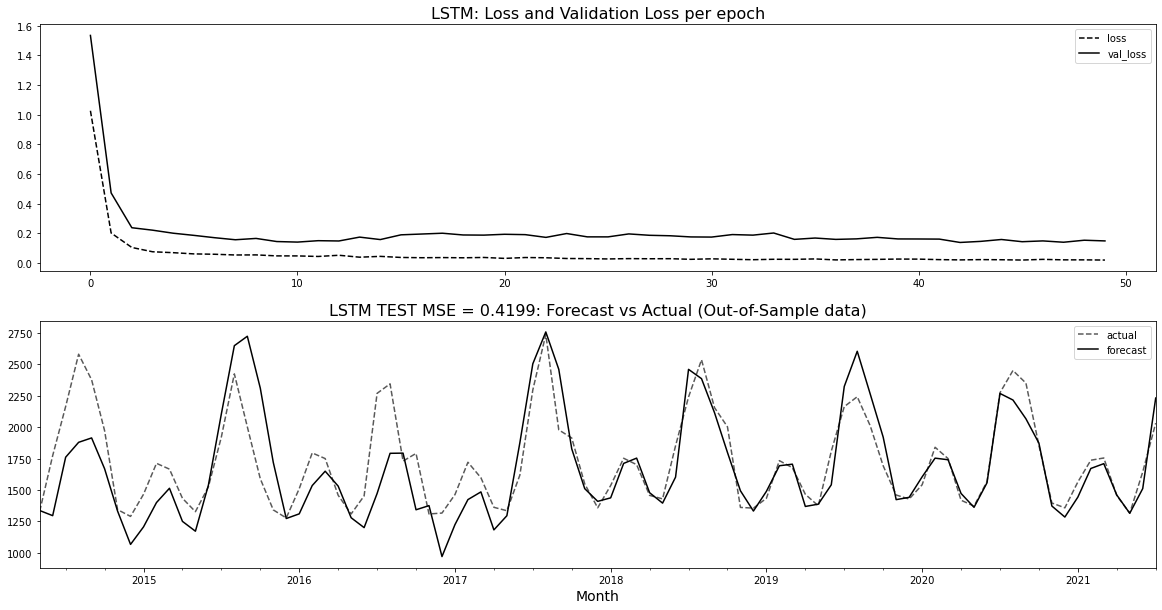

In [24]:
en_lstm, history_en_lstm = train('LSTM', **params_en)

## GRU
* The math from the PyTorch GRU documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [25]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.rnn(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

### Air Passenger

0/1000 - Loss:  0.9692283868789673, val_loss: 2.415964126586914
25/1000 - Loss:  0.21848297119140625, val_loss: 0.40863361954689026
50/1000 - Loss:  0.09265656769275665, val_loss: 0.41122761368751526
75/1000 - Loss:  0.046397700905799866, val_loss: 0.22069349884986877
100/1000 - Loss:  0.035521648824214935, val_loss: 0.17416410148143768
125/1000 - Loss:  0.04625289514660835, val_loss: 0.14428140223026276
150/1000 - Loss:  0.04057079553604126, val_loss: 0.14239998161792755
175/1000 - Loss:  0.02596740424633026, val_loss: 0.17257894575595856
200/1000 - Loss:  0.028340686112642288, val_loss: 0.15919679403305054
225/1000 - Loss:  0.02461942471563816, val_loss: 0.17912717163562775
250/1000 - Loss:  0.02830856293439865, val_loss: 0.19289067387580872
275/1000 - Loss:  0.025218745693564415, val_loss: 0.14312851428985596
300/1000 - Loss:  0.02504134736955166, val_loss: 0.11414512246847153
325/1000 - Loss:  0.023010384291410446, val_loss: 0.13382326066493988
350/1000 - Loss:  0.02201764099299907

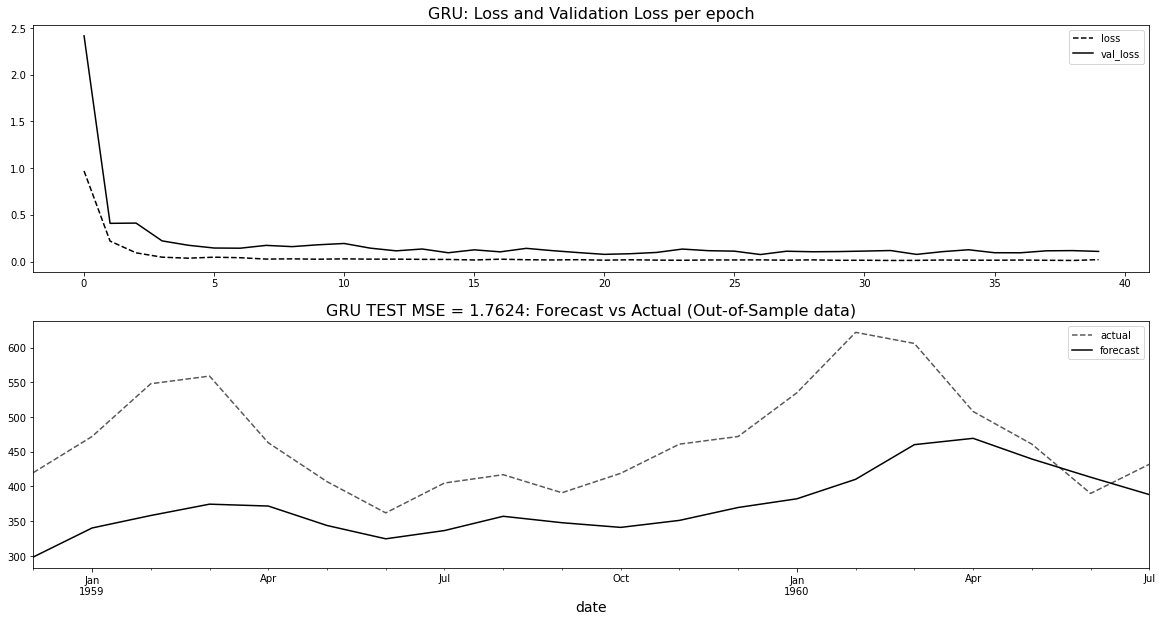

In [26]:
air_gru, history_a_gru = train('GRU', **params_air)

### Avg Daily Temperature

0/1000 - Loss:  0.9953423142433167, val_loss: 0.7275151014328003
20/1000 - Loss:  0.4468477666378021, val_loss: 0.3249429762363434
40/1000 - Loss:  0.3723970353603363, val_loss: 0.310743510723114
60/1000 - Loss:  0.3513995110988617, val_loss: 0.301617294549942
80/1000 - Loss:  0.310487300157547, val_loss: 0.3121514320373535
100/1000 - Loss:  0.2815829813480377, val_loss: 0.27822747826576233
120/1000 - Loss:  0.2456902116537094, val_loss: 0.27250009775161743
140/1000 - Loss:  0.2534789741039276, val_loss: 0.25883275270462036
160/1000 - Loss:  0.2178930789232254, val_loss: 0.2789468765258789
180/1000 - Loss:  0.19618543982505798, val_loss: 0.27517515420913696
200/1000 - Loss:  0.20310598611831665, val_loss: 0.2723132073879242
220/1000 - Loss:  0.18790453672409058, val_loss: 0.2695804238319397
240/1000 - Loss:  0.17384706437587738, val_loss: 0.30127161741256714
260/1000 - Loss:  0.17084072530269623, val_loss: 0.3270871639251709
280/1000 - Loss:  0.15718713402748108, val_loss: 0.3362778127

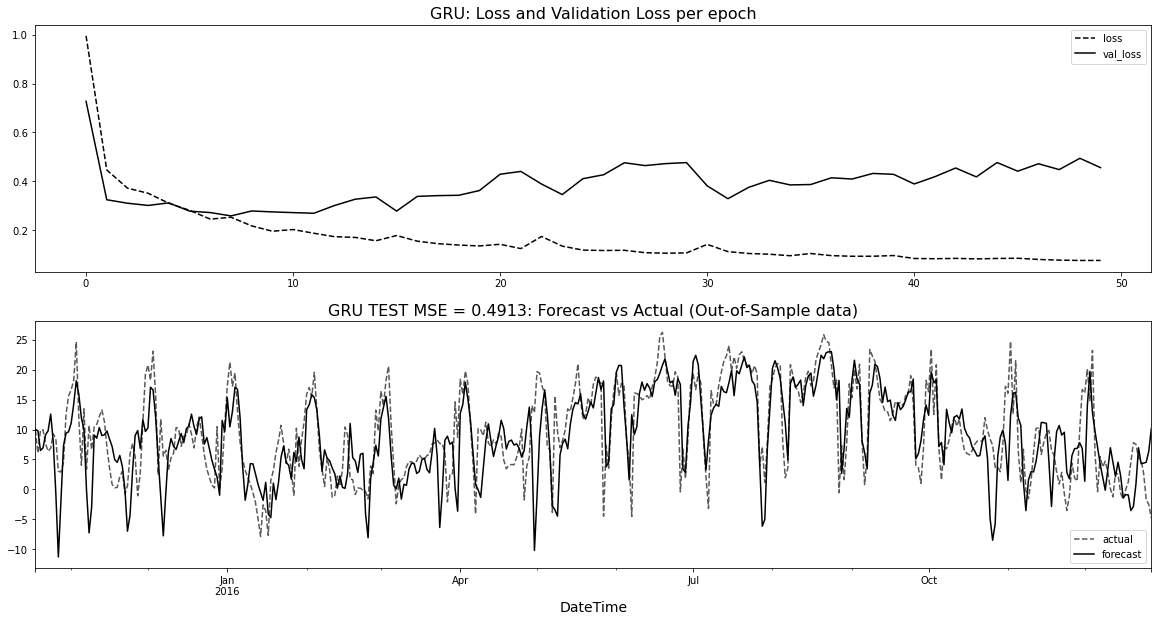

In [27]:
dw_gru, history_dw_gru = train('GRU', **params_dw)

### Energy Consumption

0/1000 - Loss:  0.9912051558494568, val_loss: 1.4191206693649292
20/1000 - Loss:  0.17877189815044403, val_loss: 0.3397286534309387
40/1000 - Loss:  0.09294822067022324, val_loss: 0.19937868416309357
60/1000 - Loss:  0.07337277382612228, val_loss: 0.18994736671447754
80/1000 - Loss:  0.0697164312005043, val_loss: 0.18722014129161835
100/1000 - Loss:  0.060049042105674744, val_loss: 0.17853453755378723
120/1000 - Loss:  0.053221676498651505, val_loss: 0.17535817623138428
140/1000 - Loss:  0.05445048213005066, val_loss: 0.1738767921924591
160/1000 - Loss:  0.05505840852856636, val_loss: 0.18017330765724182
180/1000 - Loss:  0.05229434743523598, val_loss: 0.17126509547233582
200/1000 - Loss:  0.0499819777905941, val_loss: 0.17708532512187958
220/1000 - Loss:  0.043181803077459335, val_loss: 0.19671770930290222
240/1000 - Loss:  0.047431863844394684, val_loss: 0.189993217587471
260/1000 - Loss:  0.04094869643449783, val_loss: 0.20267558097839355
280/1000 - Loss:  0.04321565106511116, val_l

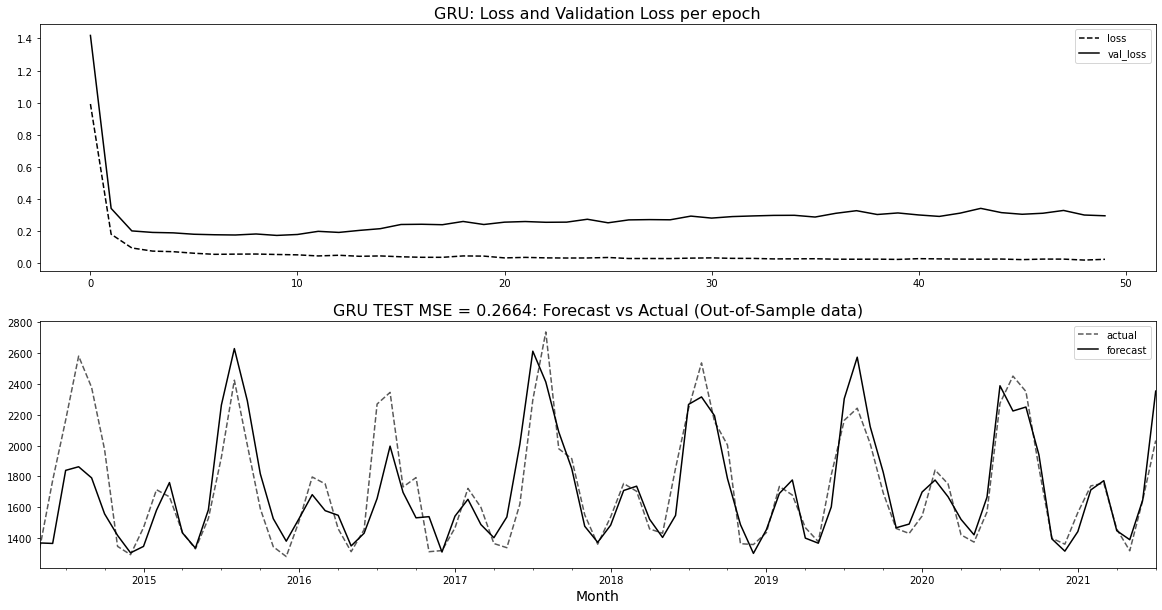

In [28]:
en_gru, history_en_gru = train('GRU', **params_en)

## There is more

In [74]:
n_hidden = 32
input_size = x_train_air.shape[1]
n_layers = 1
output = 1

In [75]:
model = torch.nn.Sequential(
    torch.nn.LSTM(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)